# Predict Nighttime Light Intensities from Daytime Light 

First pass.  
Current Goal: Use CNN to extract features from daytime lights (Landsat) data and predict levels of nighhtime light intensities (VIIRS).
***
General Steps:
- Import the data
- Feature creation
- Build the Neural Net
- Evaluate the Neural Net

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

# Import the data

8-bit image shape: (256, 256)
16-bit image shape: (2048, 3072, 3)


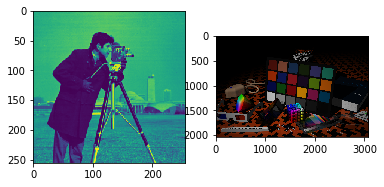

In [12]:
#Importing sample 8-bit and 16-bit tif files
os.chdir("/Users/nguyenluong/wb_internship/Data/satellite_raw")

fig, (ax0, ax1) = plt.subplots(1, 2)

bit_8 = plt.imread('sample_8bit.tif')
ax0.imshow(bit_8)
array_8 = np.array(bit_8)
print('8-bit image shape: {}'.format(array_8.shape))

bit_16 = plt.imread('sample_16bit.tif')
ax1.imshow(bit_16)
array_16 = np.array(bit_16)
print('16-bit image shape: {}'.format(array_16.shape))

In [20]:
#Load daytime Landsat data
filepath_day = 'Landsat/2011/stacked/1.tif'
im_day = plt.imread(filepath_day)
plt.imshow(im_day);
array_day = np.array(im_day)
print('daytime image shape: {}'.format(array_day.shape))

UnidentifiedImageError: cannot identify image file 'Landsat/2011/stacked/1.tif'

nighttime image shape: (1987, 2519, 4)


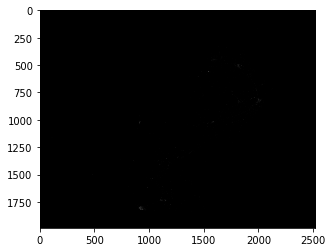

In [21]:
#Load nighttime VIIRS data
filepath_night = 'VIIRS/VIIRS Annual/pak_viirs_median_2012.tif'
im_night = plt.imread(filepath_night)
plt.imshow(im_night);
array_night = np.array(im_night)
print('nighttime image shape: {}'.format(array_night.shape))

Issues:  
- daytime lights (Landsat) files not reading in despite other 8-bit sample files reading in fine even with different methods/packages used
- nighttime lights (VIIRS) housed in 32-bit tif files and no package has been able to read that without compressing so far
- nighttime lights only to get at nighttime light intensities to serve as the values we bucket to make our target labels, so is there another way to get at that without reading in the 32-bit tif?
***
Other methods/packages of reading in 8-bit, 16-bit, and 32-bit tif files tried so far:  
- PIL Image
- opencv-python cv2
- pylibtiff
- tifffile 
- pyrsgis (currently installing necessary modules)

# Feature Creation
Reshape the data into an array of 3D tensors and normalize each element so that each pixel value is between 0 and 255. Since the Landsat data is an 8-bit data, the minimum and maximum values are 0 and 255 (2⁸ = 256 values).
***  
*Current Assumptions/Parameters*
- data_train, data_test: (np.array) 3D array containing 2D arrays each representing one 8-bit Lansat image
- target_train, target_test: (np.array with elements in range(0,5)) 1D array of nighttime light intensities split into 5 buckets

In [ ]:
# Image Dimensions
channels = 1
height = data_train[0].shape[0]
width = data_train[0].shape[1]

# Reshape the image data into features.
data_train = data_train.reshape(data_train.shape[0], channels, height, width)
data_test = data_test.reshape(data_test.shape[0], channels, height, width)

# Normalize the features
features_train = data_train / 255
features_test = data_test / 255

Each potential label will be an output node in the neural network and so each possible class needs to be mapped to a value for each target label. We perform this operation with a one-hot encoding of the labels.

In [ ]:
# One-Hot Encode Target
target_train = np_utils.to_categorical(target_train)
target_test = np_utils.to_categorical(target_test)
number_of_classes = target_test.shape[1] #should equal to 5

# Build the CNN

In [ ]:
net = Sequential()

# CNN:
# 64 filters
# 5x5 window
# ReLu Activation
net.add(Conv2D(filters=64,
               kernel_size=(5, 5),
               input_shape=(channels,width,height),
               activation='relu'))

# Pooling with a 2x2 window
net.add(MaxPooling2D(pool_size=(2,2)))

# Dropout Layer
net.add(Dropout(0.5))

# Flattening Layer
net.add(Flatten())

# Fully Connected Layer
net.add(Dense(128, activation='relu'))

# Dropout Layer
net.add(Dropout(0.5))

# Fully Connected Layer with softmax.
net.add(Dense(number_of_classes, activation='softmax'))

In [ ]:
#Compiling and training the net, selecting evaluation metric
net.compile(loss="categorical_crossentropy",
            optimizer="rmsprop",
            metrics=["accuracy"])

# Run the model
net.fit(features_train, target_train, epochs=2)

# Evaluate the CNN

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Predict for test data 
target_pred = net.predict(features_test)

# Calculate and display the error metrics
confusion_matrix = confusion_matrix(target_test, target_pred)
accuracy = accuracy_score(target_test, target_pred)
precision = precision_score(target_test, target_pred)
recall = recall_score(target_test, target_pred)

sns.heatmap(confusion_matrix, annot=True, fmt='d');